# Phase-Field Crystal Simulation in 1D


# Installation

### Plotly

- `conda install -c plotly plotly=5.7.0`
- `conda install -c conda-forge python-kaleido`


In [140]:
from IPython.display import clear_output
import os, time, pickle
import matplotlib.pyplot as plt
import numpy as np
import csv


# Parameters


In [141]:
Pi = np.pi  # Pi value
n = 32  # Number of grid
L = 8.5 * np.pi  # Length of the domain
eps = 0.2  # Undercooling degree
phiBar = 0.2  # Average density
phiAmp = phiBar * 2  # Amplitude of the initial perturbation
dx = L / n  # Grid spacing
dt = 1  # Time step
tStart = 0  # Time start
tEnd = 100  # Time end



In [142]:
# Number of time step
mTotal = int(np.ceil((tEnd - tStart) / dt)) + 1

# Recalculate tEnd in case the specified value is not consistent with mTotal
tEnd = tStart + (mTotal - 1) * dt

print(f"Total time steps: {mTotal}")
print(f"Time: {tStart} -> {tEnd}")

# Calculate array of time steps and time
mArray = np.arange(0, mTotal)
tArray = np.linspace(tStart, tEnd, mTotal)


Total time steps: 101
Time: 0 -> 100


In [143]:
# Parameter for skipping plotting (animation)
mPlotSkip = 20 


# Construct initial density profile


0.2


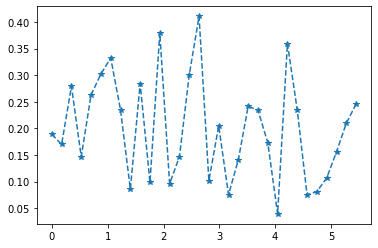

In [144]:
# Calculate X and phi
x = np.linspace(0, 2 * Pi - dx, n)

# Make sure that the average is phi_bar
phi = np.random.random(n)
# width = int(np.floor(n * 0.4))
# left = int(n / 2 - width)
# right = int(n / 2 + width)
# phi[left:right] = 0
phiAve = np.sum(phi) / n
phi = (phi - phiAve) * phiAmp + phiBar

print(np.sum(phi) / n)

plt.figure()
plt.plot(x, phi, "*--")


# Evolution


In [145]:
def live_plot(x, y, figsize=(13, 5), title="", ylim=[-1, 1]):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(x, np.real(y), "*-")
    plt.title(title)
    plt.ylim(ylim)
    plt.grid(True)
    plt.show()
    plt.pause(0.05)


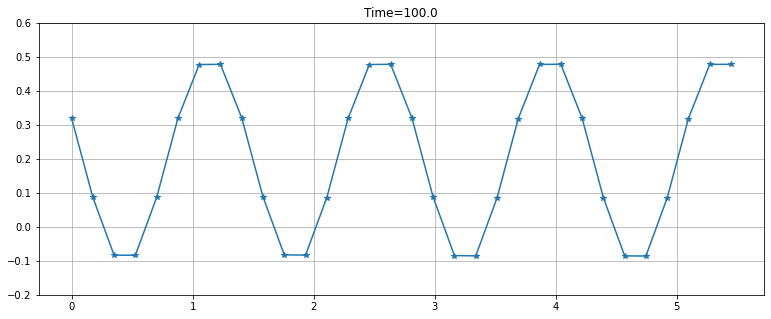

In [146]:
%matplotlib inline

phiOld = phi
ylim = [-0.2, 0.6]
k = 2 * Pi / L * np.concatenate((np.arange(0, n / 2), np.arange(-n / 2, 0)))  # or np.fft.fftfreq(100, d=dx/L)
k2 = np.power(k, 2)
k4 = np.power(k, 4)
k6 = np.power(k, 6)

# Storing data
data = np.zeros((mTotal, n))
data[0,:] = phiOld # Initial data
for m in mArray[1:]: #Use [1] to skip overwriting inital data
    t = tArray[m]
    phiOldHat = np.fft.fft(phiOld)
    phiCubeOldHat = np.fft.fft(np.power(phiOld,3))
    numerator = -dt * k2 * phiCubeOldHat + phiOldHat 
    denominator = 1 + dt * (1 - eps) * k2 - 2 * dt * k4 + dt * k6
    phiNewHat = np.divide(numerator , denominator)
    phiNew = np.fft.ifft(phiNewHat)
    phiOld = np.real(phiNew)

    data[m, :] = phiOld

    if np.mod(m, mPlotSkip) == 0:
        live_plot(x, phiOld, title=f'Time={t}', ylim=ylim)

# Visualization


In [147]:
# Surface plot using matplotlib

# from matplotlib import cm
# fig, ax = plt.subplots(figsize=(10,10),subplot_kw={"projection": "3d"})
# X, Y = np.meshgrid(x, tArray)
# surf = ax.plot_surface(X, Y, data, cmap=cm.coolwarm, linewidth=0, antialiased=False)



In [148]:
# Make output folder
timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
cwd = os.getcwd()
folderPath = os.path.join(cwd, "output", timestamp)
if not (os.path.exists(folderPath)):
    os.mkdir(folderPath)


In [149]:
import plotly.express as px

mArraySam = np.floor(np.linspace(0, mTotal - 1, 5)).astype(np.int)
tArraySam = tArray[mArraySam]
# Limit
# idxLast = mArray[-1]
# dataLast = data[:, idxLast]
ylim = [np.min(data), np.max(data)]
#
for m in mArraySam:
    t = tArray[m]
    fig = px.line(x=x, y=data[m, :], title=f"Time={t}", markers=True)
    fig.update_layout(
        xaxis_title="X", yaxis_title="Atomic Density", yaxis=dict(range=ylim)
    )

    fig.show()
    filePath = os.path.join(folderPath, f"profile_t_{t}.png")
    fig.write_image(filePath)


In [150]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=data, x=x, y=mArray)])

fig.update_layout(
    title="Density Profile",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Time",
        zaxis_title="Atomic Density",
        aspectmode="manual",
        aspectratio=dict(x=2, y=1, z=1),
    ),
    autosize=False,
    height=600,
    width=800,
    margin=dict(l=65, r=50, b=65, t=90),
    scene_camera=dict(
        up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=-0.2), eye=dict(x=1, y=-2, z=1)
    ),
)

filePath = os.path.join(folderPath, f"surface_plot.png")
fig.write_image(filePath)

fig.show()



# Writing data to file


In [151]:
params = dict(
    Pi=Pi,
    n=n,
    L=L,
    eps=eps,
    phiBar=phiBar,
    phiAmp=phiAmp,
    dx=dx,
    dt=dt,
    tStart=tStart,
    tEnd=tEnd,
)
data_store = {**params, **dict(mArray=mArray, tArray=tArray, data=data)}

# Store data in pickle file
filePath = os.path.join(folderPath, "data_store.pickle")
with open(filePath, "wb") as handle:
    pickle.dump(data_store, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Store parameters in CSV file
filePath = os.path.join(folderPath, "parameters.csv")
with open(filePath, "w") as f:
    f.write("%s,%s\n" % ("parameter", "value"))
    for key in params.keys():
        f.write("%s,%s\n" % (key, params[key]))
